In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install stable_baselines3
!pip install sb3_contrib
!pip install --upgrade ipywidgets ipykernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import configure
import stable_baselines3 as sb3
import math

In [4]:
#Định nghĩa các biến toàn cục
P_bess_max = 500.0
cap_max = 2000.0
noise_percentage = 0.08
max_steps = 24

Gen1_max = 560
Gen2_max = 630
Gen3_max = 410
Gen4_max = 1000
Gen5_max = 1000

In [5]:
# Hàm map_value được sử dụng để ánh xạ action từ khoảng [-1, 1] sang khoảng giá trị thực tế
def map_value(x, in_min, in_max, out_min, out_max):
    # Công thức chuyển đổi giá trị
    return (x - in_min) / (in_max - in_min) * (out_max - out_min) + out_min

In [6]:
# Hàm chuyển đổi action từ [-1, 1] sang phần trăm [0, 100]
def to_percentage(action_value):
    return (action_value + 1) * 50

In [7]:
def _add_percentage_noise(data, percentage=0.08, seed=None):
    if seed is not None:
        np.random.seed(seed) # Đặt seed

    lower_bound = 1 - percentage
    upper_bound = 1 + percentage
    factors = np.random.rand(*data.shape) * (upper_bound - lower_bound) + lower_bound
    noisy_data = data * factors

    return noisy_data

In [8]:
import numpy as np

# Dữ liệu gốc và tính toán hệ số
x_percent = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
fuel_efficiency = np.array([1.70, 2.50, 2.85, 3.25, 3.3, 3.4, 3.5, 3.5, 3.45])
y = 1 / fuel_efficiency

# Tính hệ số hồi quy
slopes = []
intercepts = []
for i in range(len(x_percent)-1):
    x1, x2 = x_percent[i], x_percent[i+1]
    y1, y2 = y[i], y[i+1]
    slope = (y2 - y1)/(x2 - x1)
    intercept = y1 - slope*x1
    slopes.append(slope)
    intercepts.append(intercept)

# Hàm xác định đoạn và tính toán
def get_efficiency(load_percent):
    """Tính hiệu suất theo % tải với xử lý ngoại lệ"""
    if load_percent < 0.0 or load_percent > 1.0:
        raise ValueError("Giá trị tải phải trong khoảng [0.0, 1.0]")
    # Xác định đoạn
    if load_percent < 0.1:
        segment = 0  # Dùng đoạn đầu tiên
    elif load_percent > 0.9:
        segment = 7  # Dùng đoạn cuối cùng
    else:
        segment = np.searchsorted(x_percent, load_percent) - 1

    # Tính toán giá trị
    return slopes[segment] * load_percent + intercepts[segment]

# Xuất phương trình cho 8 đoạn
print("Các phương trình tuyến tính từng đoạn:")
for i in range(8):
    print(f'Đoạn {i+1}: y = {slopes[i]:.5f}x + {intercepts[i]:.5f} '
          f'cho x ∈ [{x_percent[i]:.1f}, {x_percent[i+1]:.1f}]')


Các phương trình tuyến tính từng đoạn:
Đoạn 1: y = -1.88235x + 0.77647 cho x ∈ [0.1, 0.2]
Đoạn 2: y = -0.49123x + 0.49825 cho x ∈ [0.2, 0.3]
Đoạn 3: y = -0.43185x + 0.48043 cho x ∈ [0.3, 0.4]
Đoạn 4: y = -0.04662x + 0.32634 cho x ∈ [0.4, 0.5]
Đoạn 5: y = -0.08913x + 0.34759 cho x ∈ [0.5, 0.6]
Đoạn 6: y = -0.08403x + 0.34454 cho x ∈ [0.6, 0.7]
Đoạn 7: y = 0.00000x + 0.28571 cho x ∈ [0.7, 0.8]
Đoạn 8: y = 0.04141x + 0.25259 cho x ∈ [0.8, 0.9]


In [9]:
# Tính lượng dầu nhiều nhất có thể đạt được của mỗi máy phát:
def max_oil_usage(load_max):
    oil_usage = get_efficiency(1.0)* load_max
    return oil_usage

oil_max_gen1 = max_oil_usage(Gen1_max)
oil_max_gen2 = max_oil_usage(Gen2_max)
oil_max_gen3 = max_oil_usage(Gen3_max)
oil_max_gen4 = max_oil_usage(Gen4_max)
oil_max_gen5 = max_oil_usage(Gen5_max)

total_fuel_max = oil_max_gen1 + oil_max_gen2 + oil_max_gen3 + oil_max_gen4 + oil_max_gen5

In [48]:
soc_preset = 0.9
##Chạy code Day1

# Day 1

## Kịch bản ngày nhiều năng lượng tái tạo

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
data_load2 = {
    'Time': ['2023-10-10 00:00:00', '2023-10-10 01:00:00', '2023-10-10 02:00:00', '2023-10-10 03:00:00',
             '2023-10-10 04:00:00', '2023-10-10 05:00:00', '2023-10-10 06:00:00', '2023-10-10 07:00:00',
             '2023-10-10 08:00:00', '2023-10-10 09:00:00', '2023-10-10 10:00:00', '2023-10-10 11:00:00',
             '2023-10-10 12:00:00', '2023-10-10 13:00:00', '2023-10-10 14:00:00', '2023-10-10 15:00:00',
             '2023-10-10 16:00:00', '2023-10-10 17:00:00', '2023-10-10 18:00:00', '2023-10-10 19:00:00',
             '2023-10-10 20:00:00', '2023-10-10 21:00:00', '2023-10-10 22:00:00', '2023-10-10 23:00:00'],
    'pred': [209.145897, 202.092172, 191.892128, 190.112839, 199.870618, 210.302199, 215.088744, 217.585824,
             230.320462, 245.742942, 250.379947, 233.233375, 226.272191, 221.379410, 226.402145, 233.015409,
             255.704721, 299.521682, 315.072858, 290.642823, 280.089324, 280.603301, 270.731804, 253.868677],
    'real': [214.583333, 198.500000, 188.666667, 180.916667, 194.833333, 204.916667, 206.083333, 216.916667,
             221.750000, 231.333333, 247.666667, 214.750000, 193.000000, 185.500000, 206.750000, 229.333333,
             273.750000, 300.083333, 267.083333, 247.833333, 237.250000, 224.750000, 199.833333, 180.750000],
    'lower_bound': [179.918261, 155.904871, 158.684221, 154.753376, 158.591780, 172.440205, 175.983563, 180.648941,
                    190.478728, 198.564532, 205.301127, 187.413495, 176.443500, 172.910657, 172.743593, 185.286569,
                    207.911095, 247.154205, 265.926305, 235.335137, 205.540964, 211.417153, 196.547699, 186.924958],
    'upper_bound': [237.295510, 231.879292, 227.900025, 222.072565, 227.367184, 253.875326, 250.551132, 258.012682,
                    268.374448, 277.089882, 300.481426, 279.382792, 270.222946, 262.844765, 267.315346, 284.459380,
                    305.762687, 345.950819, 356.761076, 337.231560, 327.841767, 324.728842, 324.352698, 308.373878]
}
load_forecast2 = pd.DataFrame(data_load2)

data_wt2 = {
    'Time': ['2023-10-10 00:00:00', '2023-10-10 01:00:00', '2023-10-10 02:00:00', '2023-10-10 03:00:00',
             '2023-10-10 04:00:00', '2023-10-10 05:00:00', '2023-10-10 06:00:00', '2023-10-10 07:00:00',
             '2023-10-10 08:00:00', '2023-10-10 09:00:00', '2023-10-10 10:00:00', '2023-10-10 11:00:00',
             '2023-10-10 12:00:00', '2023-10-10 13:00:00', '2023-10-10 14:00:00', '2023-10-10 15:00:00',
             '2023-10-10 16:00:00', '2023-10-10 17:00:00', '2023-10-10 18:00:00', '2023-10-10 19:00:00',
             '2023-10-10 20:00:00', '2023-10-10 21:00:00', '2023-10-10 22:00:00', '2023-10-10 23:00:00'],
    'WT_pred': [386.337105, 385.861497, 383.705083, 386.961671, 385.930126, 387.466780, 385.385586, 385.467371,
                386.415001, 387.257877, 387.865787, 384.544665, 384.698724, 384.212587, 385.459849, 387.047390,
                387.365560, 386.337105, 391.257349, 393.631201, 391.554079, 390.972733, 391.257349, 386.396249]
}
WT_forecast2 = pd.DataFrame(data_wt2)


data_pv2 = {
    'Time': ['2023-10-10 00:00:00', '2023-10-10 01:00:00', '2023-10-10 02:00:00', '2023-10-10 03:00:00',
             '2023-10-10 04:00:00', '2023-10-10 05:00:00', '2023-10-10 06:00:00', '2023-10-10 07:00:00',
             '2023-10-10 08:00:00', '2023-10-10 09:00:00', '2023-10-10 10:00:00', '2023-10-10 11:00:00',
             '2023-10-10 12:00:00', '2023-10-10 13:00:00', '2023-10-10 14:00:00', '2023-10-10 15:00:00',
             '2023-10-10 16:00:00', '2023-10-10 17:00:00', '2023-10-10 18:00:00', '2023-10-10 19:00:00',
             '2023-10-10 20:00:00', '2023-10-10 21:00:00', '2023-10-10 22:00:00', '2023-10-10 23:00:00'],
    'PV_pred': [0, 0, 0, 0, 0, 0, 0, 11.246999, 26.969547, 30.553504,
                60.197833, 37.442088, 27.553459, 21.074532, 18.885042,
                15.689424, 14.635436, 13.393112, 0, 0, 0, 0, 0, 0]
}
PV_forecast2 = pd.DataFrame(data_pv2)

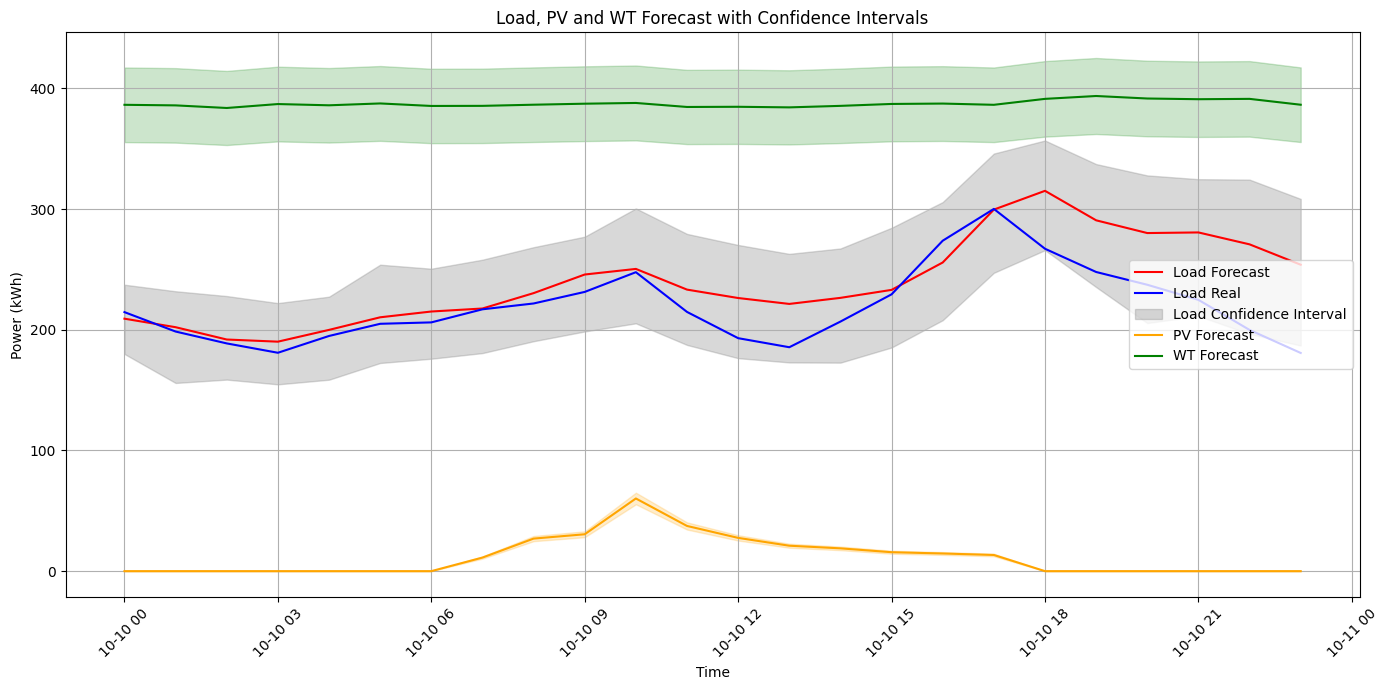

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Chuyển đổi cột 'Time' thành định dạng datetime
load_forecast2['Time'] = pd.to_datetime(load_forecast2['Time'])
PV_forecast2['Time'] = pd.to_datetime(PV_forecast2['Time'])
WT_forecast2['Time'] = pd.to_datetime(WT_forecast2['Time'])

# Ghép các bảng theo thời gian
df = load_forecast2.merge(PV_forecast2, on='Time').merge(WT_forecast2, on='Time')

# Tính toán dải ±8% cho PV và WT
df['PV_lower'] = df['PV_pred'] * 0.92
df['PV_upper'] = df['PV_pred'] * 1.08

df['WT_lower'] = df['WT_pred'] * 0.92
df['WT_upper'] = df['WT_pred'] * 1.08

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Dải xám giữa lower_bound và upper_bound
plt.plot(df['Time'], df['pred'], color='red', label='Load Forecast')
plt.plot(df['Time'], df['real'], color='blue', label='Load Real')
plt.fill_between(df['Time'], df['lower_bound'], df['upper_bound'], color='gray', alpha=0.3, label='Load Confidence Interval')

# Dự báo và dải ±8% cho PV
plt.plot(df['Time'], df['PV_pred'], color='orange', label='PV Forecast')
plt.fill_between(df['Time'], df['PV_lower'], df['PV_upper'], color='orange', alpha=0.2)

# Dự báo và dải ±8% cho WT
plt.plot(df['Time'], df['WT_pred'], color='green', label='WT Forecast')
plt.fill_between(df['Time'], df['WT_lower'], df['WT_upper'], color='green', alpha=0.2)

# Tùy chỉnh đồ thị
plt.xlabel('Time')
plt.ylabel('Power (kWh)')
plt.title('Load, PV and WT Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


## Đầu ngày

In [51]:
# Định nghĩa môi trường MinimizeProductEnv_24_4 cho OpenAI Gym/Gymnasium
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import math


class Prep(gym.Env):
    def __init__(self):
        super(Prep, self).__init__()
        # Các giá trị của hệ thống
        self.load_standard = np.array(load_forecast2['pred'])
        self.PV_standard   = np.array(data_pv2['PV_pred'])
        self.WT_standard   = np.array(data_wt2['WT_pred'])
        self.load = None
        self.ReAvai = None
        self.soc_prev = soc_preset
        self.total_fuel = 0.0
        self.total_re_used = 0.0
        self.total_waste = 0.0
        self.total_Gen_used = 0.0
        self.max_steps = max_steps

        # Obs: soc, LOAD, PV, WT, index_hour
        self.observation_space = spaces.Box(
            low=np.array([-10, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([10, np.inf, np.inf, np.inf, 24], dtype=np.float32)
        )

        # action  Gen[5], PV, WT
        self.action_space =  spaces.Box(low=np.array([-1, -1, -1, -1, -1, -1,-1], dtype=np.float32),
                                     high=np.array([1, 1, 1, 1, 1, 1, 1], dtype=np.float32))
        self.total_reward = 0

    def reset(self, seed=None, options=None, currStep=0, loadForecast=None, REforecast=None, pastRW=0, soc_preset=soc_preset):
        super().reset(seed=seed)
        self.step_count = currStep

        self.total_fuel = 0.0
        self.total_re_used = 0.0
        self.total_waste = 0.0
        self.total_Gen_used = 0.0

        # Khởi tạo P_gen_prev cho từng máy phát
        self.P_gen1_prev = 0.0
        self.P_gen2_prev = 0.0
        self.P_gen3_prev = 0.0
        self.P_gen4_prev = 0.0
        self.P_gen5_prev = 0.0

        self.total_reward = pastRW
        # Tạo kịch bản - bộ dữ liệu load, PV va WT mới với nhiễu cho mỗi episode
        self.load = np.zeros(max_steps, dtype=np.float32)

        seed = 42  # cố định seed

        # Use the seed for load generation as well
        self.load = np.array(load_forecast2['pred'])

        self.PV = np.array(data_pv2['PV_pred'])
        self.WT = np.array(data_wt2['WT_pred'])

        self.reward = 0
        self.soc_prev = soc_preset

        self.state = np.array([
            self.soc_prev,
            self.load[self.step_count],
            self.PV[self.step_count],
            self.WT[self.step_count],
            float(self.step_count)
        ], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0
        # Cập nhật trạng thái với action
        P_Gen1, P_Gen2, P_Gen3, P_Gen4, P_Gen5, P_PV, P_WT = action

        P_PV   =map_value(P_PV,-1,1,0,self.PV[self.step_count])
        P_WT   =map_value(P_WT,-1,1,0,self.WT[self.step_count])
        P_Gen1 =map_value(P_Gen1,-1,1,0,Gen1_max)
        P_Gen2 =map_value(P_Gen2,-1,1,0,Gen2_max)
        P_Gen3 =map_value(P_Gen3,-1,1,0,Gen3_max)
        P_Gen4 =map_value(P_Gen4,-1,1,0,Gen4_max)
        P_Gen5 =map_value(P_Gen5,-1,1,0,Gen5_max)


        #Tổng công suất huy động máy phát
        P_Gen = P_Gen1 + P_Gen2 + P_Gen3 + P_Gen4 + P_Gen5

        # Tính lượng dầu tiêu thụ cho từng máy phát (lít/h)
        fuel_gen1 = get_efficiency(P_Gen1/Gen1_max) * P_Gen1
        fuel_gen2 = get_efficiency(P_Gen2/Gen2_max) * P_Gen2
        fuel_gen3 = get_efficiency(P_Gen3/Gen3_max) * P_Gen3
        fuel_gen4 = get_efficiency(P_Gen4/Gen4_max) * P_Gen4
        fuel_gen5 = get_efficiency(P_Gen5/Gen5_max) * P_Gen5

        # Tổng lượng dầu tiêu thụ
        total_fuel = fuel_gen1 + fuel_gen2 + fuel_gen3 + fuel_gen4 + fuel_gen5

        #Chuẩn hóa tỉ lệ dầu tiêu thụ
        total_fuel_normalize = fuel_gen1/oil_max_gen1 + fuel_gen2/oil_max_gen2 + fuel_gen3/oil_max_gen3 + fuel_gen4/oil_max_gen4 + fuel_gen5/oil_max_gen5\

        total_fuel_normalize2 = total_fuel/total_fuel_max

        #Tính toán lượng công suất tái tạo sử dụng
        P_Re = P_PV + P_WT
        P_ReAvai = self.PV[self.step_count] + self.WT[self.step_count]

        #Tính toán lượng công suất tái tạo lãng phí
        P_waste = P_ReAvai - P_Re

        #Chuẩn hóa tỉ lệ năng lượng tái tạo lãng phí
        P_waste_normalize = P_waste/P_ReAvai

        #Tính toán ràng buộc cho công suất nạp/xả BESS
        Ebess_max=min(P_bess_max,self.soc_prev*cap_max)
        Ebess_min=max(-P_bess_max,-(1-self.soc_prev)*cap_max)

        #Cộng thêm công suất tự dùng của WT
        load = self.load[self.step_count] + 11

        #tính Ebess
        P_bess= load - P_PV - P_WT - P_Gen
        soc = self.soc_prev-P_bess / cap_max

        # Tính Reward
        bess_violation_penalty = max(0, P_bess - Ebess_max) + max(0, Ebess_min - P_bess)

        bess_violation_penalty_normalize = max(0, abs(P_bess/P_bess_max) - 1)

        soc_violation_penalty = max(0, soc - 1) + max(0, -soc)

        reward = -0.01 * (total_fuel_normalize2 + P_waste_normalize) - 20 * (soc_violation_penalty + bess_violation_penalty_normalize)

        self.reward = reward

        #Tính lượng dầu và năng lượng tái tạo sử dụng
        self.total_fuel += total_fuel
        self.total_re_used += P_Re
        self.total_waste += P_waste
        self.total_Gen_used += P_Gen

        #Cập nhật soc
        self.soc_prev=soc

        self.total_reward += (reward)

        self.step_count += 1

        if self.step_count >= max_steps:
            self.state = np.array([
            soc,                                     # Updated SOC
            0,
            0,
            0,
            float(self.step_count),                  # Current time step
            ], dtype=np.float32)
        else:
            self.state = np.array([
            self.soc_prev,
            self.load[self.step_count],
            self.PV[self.step_count],
            self.WT[self.step_count],
            float(self.step_count),
        ], dtype=np.float32)


        # Điều kiện kết thúc episode
        # SOC vượt ngưỡng THẬT SỰ (trước khi clip)
        terminated = (soc > 1.0) or (soc < 0.0)
        # Hết bước mà không bị terminated sớm
        truncated = (self.step_count >= 24)

        terminated = bool(terminated) # or terminated = True if terminated else False
        truncated = bool(truncated)

        return self.state, self.reward, terminated,truncated, {
        "total_reward": self.total_reward,
        "total_Gen_used": self.total_Gen_used,
        "total_fuel_episode": self.total_fuel,  # Thêm mới
        "total_re_episode": self.total_re_used, # Thêm mới
        "total_waste_episode": self.total_waste # Thêm mới
    }



    # Phương thức render: Hiển thị trạng thái hiện tại của môi trường
    def render(self):
        # In thông báo reset nếu là bước 0
        if self.step_count == 0:
            print("Environment reset. Ready to start.")
        # In thông tin chi tiết cho các bước sau bước 0
        elif self.step_count > 0:
            # step_idx là index của bước VỪA KẾT THÚC (step_count-1)
            step_idx = self.step_count - 1
            print(f"*************************** Step: {step_idx}/{self.max_steps-1} **********************************")

            # Kiểm tra index có hợp lệ với các list dữ liệu đã ghi lại không
            if step_idx < len(self.Ge_ar):
                print(f"  Action: Ge={self.Ge_ar[step_idx]:.2f}, Re={self.Re_ar[step_idx]:.2f}, Ebess={self.Be_ar[step_idx]:.2f}")

                print(f"  State: Load={self.load_[step_idx]:.2f}, RE_Avail={self.ReAvai[step_idx]:.2f}, SOC={self.soc[step_idx]*100:.2f}%")

                print(f"  Reward: {self.reward:.4f}, Total Reward (so far): {self.total_reward:.4f}")
            else:
                # Trường hợp này ít xảy ra nếu render được gọi đúng sau step
                print(f"  Render called at step {self.step_count} but no data logged for step {step_idx}.")


    # Phương thức close: Dọn dẹp tài nguyên (nếu cần)
    def close(self):

        pass # Hiện tại không có tài nguyên cần dọn dẹp đặc biệt

In [52]:
new_PV_forecast = _add_percentage_noise(np.array(data_pv2['PV_pred']), 0.08, 60)
new_WT_forecast = _add_percentage_noise(np.array(data_wt2['WT_pred']), 0.08, 60)

In [53]:
# Định nghĩa môi trường MinimizeProductEnv_24_4 cho OpenAI Gym/Gymnasium
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import math


class Real(gym.Env):
    def __init__(self):
        super(Real, self).__init__()
        # Các giá trị của hệ thống
        self.max_steps = 24
        self.load_standard = np.array(load_forecast2['real'])
        self.PV_standard   = new_PV_forecast
        self.WT_standard   = new_WT_forecast
        self.noise_percentage = 0.08
        self.load = None
        self.ReAvai = None
        self.soc_prev = soc_preset
        self.total_fuel = 0.0
        self.total_re_used = 0.0
        self.total_waste = 0.0
        self.total_Gen = 0.0


        # Obs: soc, LOAD, PV, WT, index_hour, GEN_PREV[5]
        self.observation_space = spaces.Box(
            low=np.array([-10, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([10, np.inf, np.inf, np.inf, 24], dtype=np.float32)
        )

        # action  Gen[5], PV, WT
        self.action_space =  spaces.Box(low=np.array([-1, -1, -1, -1, -1, -1,-1], dtype=np.float32),
                                     high=np.array([1, 1, 1, 1, 1, 1, 1], dtype=np.float32))
        self.total_reward = 0

    def reset(self, seed=None, options=None, currStep=0, loadForecast=None, REforecast=None, pastRW=0, soc_preset=soc_preset):
        super().reset(seed=seed)
        self.total_fuel = 0.0
        self.total_re_used = 0.0
        self.total_waste = 0.0
        self.total_Gen = 0.0
        self.step_count = currStep
        self.total_reward = pastRW

        # Tạo kịch bản - bộ dữ liệu load, PV va WT mới với nhiễu cho mỗi episode
        self.load = self.load_standard
        self.PV = self.PV_standard
        self.WT = self.WT_standard

        self.reward = 0
        self.soc_prev = soc_preset

        self.state = np.array([
            self.soc_prev,
            self.load[self.step_count],
            self.PV[self.step_count],
            self.WT[self.step_count],
            float(self.step_count)
        ], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0
        # Cập nhật trạng thái với action
        P_Gen1, P_Gen2, P_Gen3, P_Gen4, P_Gen5, P_PV, P_WT = action

        P_PV   =map_value(P_PV,-1,1,0,self.PV[self.step_count])
        P_WT   =map_value(P_WT,-1,1,0,self.WT[self.step_count])
        P_Gen1 =map_value(P_Gen1,-1,1,0,Gen1_max)
        P_Gen2 =map_value(P_Gen2,-1,1,0,Gen2_max)
        P_Gen3 =map_value(P_Gen3,-1,1,0,Gen3_max)
        P_Gen4 =map_value(P_Gen4,-1,1,0,Gen4_max)
        P_Gen5 =map_value(P_Gen5,-1,1,0,Gen5_max)


        #Tổng công suất huy động máy phát
        P_Gen = P_Gen1 + P_Gen2 + P_Gen3 + P_Gen4 + P_Gen5

        # Tính lượng dầu tiêu thụ cho từng máy phát (lít/h)
        fuel_gen1 = get_efficiency(P_Gen1/Gen1_max) * P_Gen1
        fuel_gen2 = get_efficiency(P_Gen2/Gen2_max) * P_Gen2
        fuel_gen3 = get_efficiency(P_Gen3/Gen3_max) * P_Gen3
        fuel_gen4 = get_efficiency(P_Gen4/Gen4_max) * P_Gen4
        fuel_gen5 = get_efficiency(P_Gen5/Gen5_max) * P_Gen5

        # Tổng lượng dầu tiêu thụ
        total_fuel = fuel_gen1 + fuel_gen2 + fuel_gen3 + fuel_gen4 + fuel_gen5

        #Chuẩn hóa tỉ lệ dầu tiêu thụ
        total_fuel_normalize = fuel_gen1/oil_max_gen1 + fuel_gen2/oil_max_gen2 + fuel_gen3/oil_max_gen3 + fuel_gen4/oil_max_gen4 + fuel_gen5/oil_max_gen5\

        total_fuel_normalize2 = total_fuel/total_fuel_max

        #Tính toán lượng công suất tái tạo sử dụng
        P_Re = P_PV + P_WT
        P_ReAvai = self.PV[self.step_count] + self.WT[self.step_count]

        #Tính toán lượng công suất tái tạo lãng phí
        P_waste = P_ReAvai - P_Re

        #Chuẩn hóa tỉ lệ năng lượng tái tạo lãng phí
        P_waste_normalize = P_waste/P_ReAvai

        #Tính toán ràng buộc cho công suất nạp/xả BESS
        Ebess_max=min(P_bess_max,self.soc_prev*cap_max)
        Ebess_min=max(-P_bess_max,-(1-self.soc_prev)*cap_max)

        #Cộng thêm công suất tự dùng của WT
        load = self.load[self.step_count] + 11

        #tính Ebess
        P_bess= load - P_PV - P_WT - P_Gen
        soc = self.soc_prev-P_bess / cap_max

        # Tính Reward
        bess_violation_penalty = max(0, P_bess - Ebess_max) + max(0, Ebess_min - P_bess)

        bess_violation_penalty_normalize = max(0, abs(P_bess/P_bess_max) - 1)

        soc_violation_penalty = max(0, soc - 1) + max(0, -soc)

        reward = -0.01 * (total_fuel_normalize2 + P_waste_normalize) - 20 * (soc_violation_penalty + bess_violation_penalty_normalize)

        self.reward = reward

        #Tính lượng dầu và năng lượng tái tạo sử dụng
        self.total_fuel += total_fuel
        self.total_re_used += P_Re
        self.total_waste += P_waste
        self.total_Gen += P_Gen

        #Cập nhật soc
        self.soc_prev=soc

        self.total_reward += (reward)

        self.step_count += 1

        if self.step_count >= max_steps:
            self.state = np.array([
            soc,                                     # Updated SOC
            0,
            0,
            0,
            float(self.step_count),                  # Current time step
            ], dtype=np.float32)
        else:
            self.state = np.array([
            self.soc_prev,
            self.load[self.step_count],
            self.PV[self.step_count],
            self.WT[self.step_count],
            float(self.step_count),
        ], dtype=np.float32)


        # Điều kiện kết thúc episode
        # SOC vượt ngưỡng THẬT SỰ (trước khi clip)
        terminated = (soc > 1.0) or (soc < 0.0)
        # Hết bước mà không bị terminated sớm
        truncated = (self.step_count >= 24)

        terminated = bool(terminated) # or terminated = True if terminated else False
        truncated = bool(truncated)

        return self.state, self.reward, terminated,truncated, {
        "total_reward": self.total_reward,
        "total_fuel_episode": self.total_fuel,  # Thêm mới
        "total_re_episode": self.total_re_used, # Thêm mới
        "total_waste_episode": self.total_waste, # Thêm mới
        "total_Gen_used" : self.total_Gen
    }


    # Phương thức render: Hiển thị trạng thái hiện tại của môi trường
    def render(self):
        # In thông báo reset nếu là bước 0
        if self.step_count == 0:
            print("Environment reset. Ready to start.")
        # In thông tin chi tiết cho các bước sau bước 0
        elif self.step_count > 0:
            # step_idx là index của bước VỪA KẾT THÚC (step_count-1)
            step_idx = self.step_count - 1
            print(f"*************************** Step: {step_idx}/{self.max_steps-1} **********************************")

            # Kiểm tra index có hợp lệ với các list dữ liệu đã ghi lại không
            if step_idx < len(self.Ge_ar):
                print(f"  Action: Ge={self.Ge_ar[step_idx]:.2f}, Re={self.Re_ar[step_idx]:.2f}, Ebess={self.Be_ar[step_idx]:.2f}")

                print(f"  State: Load={self.load_[step_idx]:.2f}, RE_Avail={self.ReAvai[step_idx]:.2f}, SOC={self.soc[step_idx]*100:.2f}%")

                print(f"  Reward: {self.reward:.4f}, Total Reward (so far): {self.total_reward:.4f}")
            else:
                # Trường hợp này ít xảy ra nếu render được gọi đúng sau step
                print(f"  Render called at step {self.step_count} but no data logged for step {step_idx}.")


    # Phương thức close: Dọn dẹp tài nguyên (nếu cần)
    def close(self):

        pass # Hiện tại không có tài nguyên cần dọn dẹp đặc biệt

# Kiểm tra với giữa các kịch bản khác nhau

In [54]:
day1 = Prep()
check_env(day1)
day1.reset()
print(day1.observation_space)
print(day1.action_space)
print(day1.soc_prev)

Box([-10.   0.   0.   0.   0.], [10. inf inf inf 24.], (5,), float32)
Box(-1.0, 1.0, (7,), float32)
0.9


In [55]:
real_environment = Real()
check_env(real_environment)
real_environment.reset()
print(real_environment.observation_space)
print(real_environment.action_space)
print(real_environment.soc_prev)

Box([-10.   0.   0.   0.   0.], [10. inf inf inf 24.], (5,), float32)
Box(-1.0, 1.0, (7,), float32)
0.9


In [21]:
import numpy
import stable_baselines3
import sb3_contrib

print("numpy:", numpy.__version__)
print("stable-baselines3:", stable_baselines3.__version__)
print("sb3-contrib:", sb3_contrib.__version__)


numpy: 2.0.2
stable-baselines3: 2.6.0
sb3-contrib: 2.6.0


In [ ]:
import numpy as np

In [56]:
import gymnasium as gym
import sb3_contrib  as sb3_trib
from sb3_contrib import TRPO
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import os
import numpy as np

# Đường dẫn tới mô hình đã lưu
# Chú ý chọn đúng model với SoC ban đầu
# Bạn có thể chọn mô hình tốt nhất hoặc mô hình cuối cùng

MODEL_PATH_TRPO_bestmodel = '/content/drive/MyDrive/BLV/Model/11_6/TRPO_2nd_scenario/training_logs_final_env_ADung/best_model_soc_0.9_new_penalty2/best_model.zip'

MODEL_PATH_PPO_bestmodel = '/content/drive/MyDrive/BLV/Model/11_6/PPO_2nd_scenario/training_logs_final_env_ADung/best_model_soc_0.9_new_penalty2/best_model.zip'

# Tải mô hình đã huấn luyện
try:
    model_trpo_bestmodel = TRPO.load(MODEL_PATH_TRPO_bestmodel)

    model_ppo_bestmodel = PPO.load(MODEL_PATH_PPO_bestmodel)

    print(f"Đã tải mô hình")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Vui lòng kiểm tra lại đường dẫn mô hình và đảm bảo bạn đã cài đặt stable_baselines3 hoặc stable_baselines3-contrib.")
    #exit()

Đã tải mô hình


## Lập lịch đầu ngày

In [61]:
# Danh sách để lưu trữ kết quả

print(f"Bắt đầu kiểm tra mô hình ...")

# Reset môi trường
obs, info = day1.reset()
done = False
episode_rewards = 0

# Dữ liệu từng bước trong một episode
episode_obs = []
episode_actions = []
episode_rewards_step = []
raw_action = []

for i in range(24):  # 24 bước tương ứng 24 giờ
    episode_obs.append(obs)

    action, _states = model_ppo_bestmodel.predict(obs, deterministic=True) #Chú ý load đúng model

    # Chuyển đổi action gốc sang dạng phần trăm
    P_Gen1_percent = to_percentage(action[0])
    P_Gen2_percent = to_percentage(action[1])
    P_Gen3_percent = to_percentage(action[2])
    P_Gen4_percent = to_percentage(action[3])
    P_Gen5_percent = to_percentage(action[4])

    P_PV_percent = to_percentage(action[5])
    P_WT_percent = to_percentage(action[6])

    percent_action = np.array([P_Gen1_percent, P_Gen2_percent, P_Gen3_percent, P_Gen4_percent, P_Gen5_percent, P_PV_percent, P_WT_percent])

    raw_action.append(action)
    episode_actions.append(percent_action)


    obs, reward, terminated, truncated, info = day1.step(action)

    episode_rewards_step.append(reward)
    episode_rewards += reward

    if terminated or truncated:
        print(f"""
        Tổng lượng dầu: {info['total_fuel_episode']:.2f} lít
        Tổng điện năng máy phát: {info['total_Gen_used']:.2f} kWh
        Năng lượng tái tạo sử dụng: {info['total_re_episode']:.2f} kWh
        Lượng lãng phí: {info['total_waste_episode']:.2f} kWh
        """)
        break

# ✅ Lưu lại kết quả sau mỗi episode
print("\n--- Kết quả dự kiến ---")
print(f"Tổng Reward: {episode_rewards:.4f}")
print(f"SoC cuối: {obs[0]*100:.2f}%")
print(f"SOC ban đầu: {soc_preset}")

# In ra các actions đã thực hiện
print("\n--- Các hành động thực hiện ---")
for hour, action in enumerate(episode_actions):
    print(f"Giờ {hour}: [{action[0]: 6.2f}%, {action[1]: 6.2f}%, {action[2]: 6.2f}%, {action[3]: 6.2f}%, {action[4]: 6.2f}%, {action[5]: 6.2f}%, {action[6]: 6.2f}%]")

print("\nKiểm tra hoàn thành.")


Bắt đầu kiểm tra mô hình ...

        Tổng lượng dầu: 0.00 lít
        Tổng điện năng máy phát: 0.00 kWh
        Năng lượng tái tạo sử dụng: 5342.00 kWh
        Lượng lãng phí: 4229.03 kWh
        

--- Kết quả dự kiến ---
Tổng Reward: -0.1073
SoC cuối: 56.45%
SOC ban đầu: 0.9

--- Các hành động thực hiện ---
Giờ 0: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.42%,   1.69%]
Giờ 1: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.24%,   3.11%]
Giờ 2: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.15%,   3.24%]
Giờ 3: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.02%,   0.55%]
Giờ 4: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.16%,   4.07%]
Giờ 5: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.79%,  13.25%]
Giờ 6: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  62.46%,  38.22%]
Giờ 7: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  62.81%,  34.24%]
Giờ 8: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  64.11%,  58.89%]
Giờ 9: [  0.00%,   0.00%,   0.00%,   0.00%,   0.00

## Thực hiện lịch

In [62]:
# Danh sách để lưu trữ kết quả
# Lưu các hành động đã biến đổi
normalized_actions = []
print(f"Bắt đầu áp dụng các hành động đã hoạch định vào môi trường thật...")

# Đặt tên cho từng thành phần trong action vector
ACTION_NAMES = ["Điều khiển generator", "Điều khiển năng lượng tái tạo"]

# Các hành động đã được hoạch định trước từ môi trường giả lập
predefined_actions =  raw_action


# Reset môi trường thật
obs, info = day1.reset()
done = False
episode_rewards = 0

# Dữ liệu từng bước trong một episode
episode_obs = []
episode_rewards_step = []

print("\n--- Chi tiết từng giờ ---")
print("Giờ | SoC (%) |    Huy động tỉ lệ [Pgen1, Pgen2, Pgen3, Pgen4, Pgen5, P_PV, P_WT    |  Load  | PV Avail | WT Avail | P_BESS | Reward")
print("----|---------|---------------------------------------------------------------------|--------|----------|----------|--------|-------")

for i, action in enumerate(predefined_actions):
    if i >= 24:  # Đảm bảo không vượt quá 24 giờ
        break

    episode_obs.append(obs)
    soc_before = obs[0] * 100  # Chuyển đổi thành phần trăm

    # Lưu trạng thái trước khi áp dụng action
    current_load = day1.load[i]
    current_PV = day1.PV[i]
    current_WT = day1.WT[i]

    #current_load = real_environment_new.load[i+12]
    #current_re_avai = real_environment_new.ReAvai[i+12]

    # Tính toán các giá trị normalized action (tương tự như trong phương thức step)
    P_gen1, P_gen2, P_gen3, P_gen4, P_gen5, P_PV, P_WT = action

    # Chuyển đổi action gốc sang dạng phần trăm
    P_Gen1_percent = to_percentage(action[0])
    P_Gen2_percent = to_percentage(action[1])
    P_Gen3_percent = to_percentage(action[2])
    P_Gen4_percent = to_percentage(action[3])
    P_Gen5_percent = to_percentage(action[4])
    P_PV_percent = to_percentage(action[5])
    P_WT_percent = to_percentage(action[6])

    #Biến đổi action Gen
    normalized_Gen1 = map_value(P_gen1, -1, 1, 0, Gen1_max)
    normalized_Gen2 = map_value(P_gen2, -1, 1, 0, Gen2_max)
    normalized_Gen3 = map_value(P_gen3, -1, 1, 0, Gen3_max)
    normalized_Gen4 = map_value(P_gen4, -1, 1, 0, Gen4_max)
    normalized_Gen5 = map_value(P_gen5, -1, 1, 0, Gen5_max)

    # Biến đổi action PV
    normalized_PV = map_value(P_PV, -1, 1, 0, current_PV)

    # Biến đổi action WT
    normalized_WT = map_value(P_WT, -1, 1, 0, current_WT)

    normalized_Gen = normalized_Gen1 + normalized_Gen2 + normalized_Gen3 + normalized_Gen4 + normalized_Gen5
    P_bess = current_load - normalized_WT - normalized_PV - normalized_Gen


    # Sử dụng hành động đã hoạch định trước
    obs, reward, terminated, truncated, info = day1.step(action)


    # Lưu hành động đã biến đổi
    normalized_actions.append([normalized_Gen1, normalized_Gen2, normalized_Gen3, normalized_Gen4, normalized_Gen5, normalized_PV, normalized_WT])

    episode_rewards_step.append(reward)
    episode_rewards += reward

    # In thông tin chi tiết cho mỗi giờ với action gốc và đã biến đổi
    print(f"{i:2d}  | {soc_before:5.2f}   |  [{P_Gen1_percent:6.2f}%, {P_Gen2_percent:6.2f}%, {P_Gen3_percent:6.2f}%, {P_Gen4_percent:6.2f}%, {P_Gen5_percent:6.2f}%, {P_PV_percent:6.2f}%, {P_WT_percent:6.2f}%]    | {current_load:5.2f} |  {current_PV:6.2f}  |  {current_WT:6.2f}  | {P_bess:6.2f} | {reward:6.5f}")

    if terminated or truncated:
        print(f"""
        Tổng lượng dầu: {info['total_fuel_episode']:.2f} lít
        Tổng điện năng máy phát: {info['total_Gen_used']:.2f} kWh
        Năng lượng tái tạo sử dụng: {info['total_re_episode']:.2f} kWh
        Lượng lãng phí: {info['total_waste_episode']:.2f} kWh
        """)
        break

# ✅ Lưu lại kết quả
print("\n--- Kết quả sau khi áp dụng các hành động ---")
print(f"Tổng Reward: {episode_rewards:.4f}")
print(f"SoC cuối: {obs[0]*100:.2f}%")

print("\nÁp dụng hoàn thành.")

Bắt đầu áp dụng các hành động đã hoạch định vào môi trường thật...

--- Chi tiết từng giờ ---
Giờ | SoC (%) |    Huy động tỉ lệ [Pgen1, Pgen2, Pgen3, Pgen4, Pgen5, P_PV, P_WT    |  Load  | PV Avail | WT Avail | P_BESS | Reward
----|---------|---------------------------------------------------------------------|--------|----------|----------|--------|-------
 0  | 90.00   |  [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.42%,   1.69%]    | 209.15 |    0.00  |  386.34  | 202.60 | -0.00983
 1  | 79.32   |  [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.24%,   3.11%]    | 202.09 |    0.00  |  385.86  | 190.10 | -0.00969
 2  | 69.27   |  [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.15%,   3.24%]    | 191.89 |    0.00  |  383.71  | 179.46 | -0.00968
 3  | 59.74   |  [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.02%,   0.55%]    | 190.11 |    0.00  |  386.96  | 187.99 | -0.00995
 4  | 49.79   |  [  0.00%,   0.00%,   0.00%,   0.00%,   0.00%,  60.16%,   4.07%]    | 199.87 |    0.

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Hàm vẽ biểu đồ với Plotly
def plot_results(real_environment, episode_actions, normalized_actions):
    """
    Vẽ biểu đồ kết quả sau khi áp dụng các hành động bằng Plotly

    Parameters:
    real_environment: Đối tượng môi trường
    episode_actions: Hành động đã thực hiện
    normalized_actions: Các hành động đã được biến đổi
    """
    # Trích xuất dữ liệu
    hours = list(range(len(normalized_actions)))
    load = day1.load[:len(normalized_actions)]
    PV_avail = day1.PV[:len(normalized_actions)]
    WT_avail = day1.WT[:len(normalized_actions)]

    re_avail = PV_avail + WT_avail

    # Trích xuất SoC từ obs (giả sử đã được lưu)
    soc_values = [obs[0] * 100 for obs in episode_obs]  # Chuyển đổi sang phần trăm

    # Trích xuất hành động đã biến đổi
    normalized_ePV = [action[5] for action in normalized_actions]
    normalized_eWT = [action[6] for action in normalized_actions]
    # Trích xuất 5 máy phát điện
    normalized_p_gen1 = [action[0] for action in normalized_actions]
    normalized_p_gen2 = [action[1] for action in normalized_actions]
    normalized_p_gen3 = [action[2] for action in normalized_actions]
    normalized_p_gen4 = [action[3] for action in normalized_actions]
    normalized_p_gen5 = [action[4] for action in normalized_actions]

    # Tính tổng công suất máy phát
    total_gen = [sum(x) for x in zip(normalized_p_gen1, normalized_p_gen2,
                                    normalized_p_gen3, normalized_p_gen4, normalized_p_gen5)]

    # Tạo subplot với 2 biểu đồ
    fig = make_subplots(rows=2, cols=1,
                       subplot_titles=('Phân tích tải, năng lượng tái tạo và SoC',
                                      'Hành động thực hiện - Chi tiết 5 máy phát điện và năng lượng tái tạo'),
                       specs=[[{"secondary_y": True}],
                             [{"secondary_y": False}]])
    for annotation in fig['layout']['annotations']:
      annotation['font'] = dict(size=22)

    # Subplot 1: Load, RE Available, Total Gen và SoC
    fig.add_trace(go.Scatter(x=hours, y=load, mode='lines', name='Load',
                            line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=hours, y=re_avail, mode='lines', name='RE Available',
                            line=dict(color='green')), row=1, col=1)
    fig.add_trace(go.Scatter(x=hours, y=total_gen, mode='lines', name='Total Gen',
                            line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=hours, y=soc_values, mode='lines', name='SoC (%)',
                            line=dict(color='magenta')), row=1, col=1, secondary_y=True)

    # Subplot 2: Chi tiết PV, WT và 5 máy phát điện
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

    fig.add_trace(go.Scatter(x=hours, y=normalized_ePV, mode='lines', name='PV Used',
                            line=dict(dash='dash', color='green')), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=PV_avail, mode='lines', name='PV Available',
                            line=dict(color='darkgreen')), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=normalized_eWT, mode='lines', name='WT Used',
                            line=dict(dash='dash', color='cyan')), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=WT_avail, mode='lines', name='WT Available',
                            line=dict(color='darkcyan')), row=2, col=1)
    fig.update_layout(
    legend=dict(
        font=dict(
            size=20  # Thay đổi giá trị này theo ý muốn, ví dụ: 18, 22, 24,...
        )
      )
    )
    # Thêm 5 máy phát điện
    fig.add_trace(go.Scatter(x=hours, y=normalized_p_gen1, mode='lines', name='P_GEN1',
                            line=dict(color=colors[0])), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=normalized_p_gen2, mode='lines', name='P_GEN2',
                            line=dict(color=colors[1])), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=normalized_p_gen3, mode='lines', name='P_GEN3',
                            line=dict(color=colors[2])), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=normalized_p_gen4, mode='lines', name='P_GEN4',
                            line=dict(color=colors[3])), row=2, col=1)
    fig.add_trace(go.Scatter(x=hours, y=normalized_p_gen5, mode='lines', name='P_GEN5',
                            line=dict(color=colors[4])), row=2, col=1)
    fig.update_layout(
    legend=dict(
        font=dict(
            size=20  # Thay đổi giá trị này theo ý muốn, ví dụ: 18, 22, 24,...
        )
      )
    )
    # Cấu hình layout
    fig.update_xaxes(title_text="Giờ", row=1, col=1, title_font=dict(size=24))
    fig.update_xaxes(title_text="Giờ", row=2, col=1, title_font=dict(size=24))
    fig.update_yaxes(title_text="Năng lượng (kWh)", row=1, col=1, title_font=dict(size=24))
    fig.update_yaxes(title_text="SoC (%)", secondary_y=True, row=1, col=1, range=[0, 100], title_font=dict(size=24))
    fig.update_yaxes(title_text="Điện năng huy động (kWh)", row=2, col=1, title_font=dict(size=24))

    fig.update_layout(
        height=800,  # Tăng chiều cao cho 2 subplot
        showlegend=True,
        title_font=dict(size = 30),
        template='plotly_white',
        title_text="Phân tích vận hành hệ thống lưới điện"
    )

    # Hiển thị biểu đồ
    fig.show()

    print("Đã hiển thị biểu đồ với 5 máy phát điện.")

In [64]:
# Gọi hàm vẽ biểu đồ
plot_results(day1, episode_obs, normalized_actions)

Đã hiển thị biểu đồ với 5 máy phát điện.


# So sánh với vận hành thực tế

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd

# Thay 'ten_file.csv' bằng tên file bạn vừa upload
BESS = pd.read_csv('BESS.csv')
print(BESS.head())

Saving BESS.csv to BESS.csv
                  Time     P   SOC
0  2023-01-01 00:00:00 -11.2  48.1
1  2023-01-01 01:00:00 -50.5  54.2
2  2023-01-01 02:00:00 -38.9  60.2
3  2023-01-01 03:00:00 -43.1  66.2
4  2023-01-01 04:00:00 -33.4  72.1


In [ ]:
uploaded = files.upload()
Generators = pd.read_csv('Huy_động.csv')
print(Generators.head())

Saving Huy_động.csv to Huy_động.csv
                  Time  Gen 1&2&3  Gen 4,5   PV   Wind
0  2023-01-01 00:00:00        0.0      0.0  0.0  166.0
1  2023-01-01 01:00:00        0.0      0.0  0.0  182.0
2  2023-01-01 02:00:00        0.0      0.0  0.0  164.0
3  2023-01-01 03:00:00        0.0      0.0  0.0  165.0
4  2023-01-01 04:00:00        0.0      0.0  0.0  164.0


In [ ]:
# Chuyển cột Time về kiểu datetime cho cả hai DataFrame
BESS['Time'] = pd.to_datetime(BESS['Time'])
Generators['Time'] = pd.to_datetime(Generators['Time'])
# Merge theo cột Time, chỉ giữ lại các dòng có thời gian trùng nhau (inner join)
df_merged = pd.merge(BESS, Generators, on='Time', how='inner')
df_merged.set_index('Time', inplace=True)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
df = df_merged
# Tạo đồ thị với 3 đường (2 trên y-axis chính, 1 trên y-axis phụ)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Thêm giá trị PV
fig.add_trace(
    go.Scatter(
        name='PV',
        x=df.index,
        y=df['PV'],
        mode='lines',
        line=dict(color='blue'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị WT
fig.add_trace(
    go.Scatter(
        name='WT',
        x=df.index,
        y=df['Wind'],
        mode='lines',
        line=dict(color='orange'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị Gen 4,5
fig.add_trace(
    go.Scatter(
        name='GEN 4,5',
        x=df.index,
        y=df['Gen 4,5'],
        mode='lines',
        line=dict(color='red'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị Gen 1,2,3
fig.add_trace(
    go.Scatter(
        name='GEN 1,2,3',
        x=df.index,
        y=df['Gen 1&2&3'],
        mode='lines',
        line=dict(color='green'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị BESS
fig.add_trace(
    go.Scatter(
        name='BESS',
        x=df.index,
        y=df['P'],
        mode='lines',
        line=dict(color='yellow'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị SoC
fig.add_trace(
    go.Scatter(
        name='SOC',
        x=df.index,
        y=df['SOC'],
        mode='lines',
        line=dict(color='black'),
    ),
    secondary_y=True,  # Trục y chính
)

# Cập nhật layout
fig.update_layout(
    title="Huy động các nguồn năng lượng",
    xaxis_title="Date time",
    yaxis_title="Giá trị (kWh)",
    yaxis2_title="SoC (%)",
    width=1500,
    height=800,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
)

# Bật thanh cuộn thời gian
fig.update_xaxes(rangeslider_visible=True)

# Hiển thị đồ thị
#fig.show(renderer="colab")
fig.show()


# Kiểm tra theo base line

In [ ]:
def inverse_map_value(y, in_min, in_max, out_min, out_max):
    # Công thức chuyển đổi ngược giá trị
    return (y - out_min) / (out_max - out_min) * (in_max - in_min) + in_min

In [ ]:
import numpy as np
import random

# Khởi tạo các mảng
Re_arr = []
Ori_Re = []
Be_arr = []
Ge_arr = []
Ori_PV = []
Ori_WT= []
real_WT =[]
real_PV = []
soc_arr = []
reward_arr = []

cap_max = 2000.0
P_bess_max = 550.0
reward = 0
step = 24
preset_soc = 0.9
soc = preset_soc

# Dữ liệu chuẩn
load_standard = df['pred']
PV_standard = df['PV_pred']
WT_standard = df['WT_pred']

# Giới hạn thay đổi
change_limit = 0.1
random.seed(46)
np.random.seed(46)

# Nhiễu dữ liệu
load1_modified = load_standard * (1 + np.random.uniform(-change_limit, change_limit, size=load_standard.shape))
PVAvai1_modified = PV_standard * (1 + np.random.uniform(-change_limit, change_limit, size=PV_standard.shape))
WindAvai1_modified = WT_standard * (1 + np.random.uniform(-change_limit, change_limit, size=WT_standard.shape))

# Giả lập hàm ánh xạ ngược
def inverse_map_value(val, old_min, old_max, new_min, new_max):
    return (val - new_min) / (new_max - new_min) * (old_max - old_min) + old_min if new_max != new_min else 0

for i in range(step):
    load_demand = load_standard[i]
    wind_avail = WT_standard[i]
    pv_avail = PV_standard[i]

    Pbess_avail_discharge = min(P_bess_max, soc * cap_max)
    Pbess_avail_charge = min(P_bess_max, (1 - soc) * cap_max)

    # 1. WT cấp cho tải
    act_Re_wind_to_load = min(wind_avail, load_demand)
    wind_remaining = wind_avail - act_Re_wind_to_load
    load_demand -= act_Re_wind_to_load

    # 2. PV cấp cho tải
    act_Re_pv_to_load = min(pv_avail, load_demand)
    pv_remaining = pv_avail - act_Re_pv_to_load
    load_demand -= act_Re_pv_to_load

    # Tổng năng lượng tái tạo cấp tải
    act_Re = act_Re_wind_to_load + act_Re_pv_to_load

    # 3. Dùng BESS nếu còn thiếu
    act_Be_discharge = min(Pbess_avail_discharge, load_demand)
    load_demand -= act_Be_discharge

    # 4. Nếu còn thiếu nữa, dùng máy phát
    act_Ge = max(0, load_demand)

    # 5. Nếu dư WT + PV → sạc BESS
    renewable_surplus = wind_remaining + pv_remaining
    act_Be_charge = min(renewable_surplus, Pbess_avail_charge)

    # Ưu tiên WT để sạc, sau đó là PV
    act_Re_wind_to_bess = min(wind_remaining, act_Be_charge)
    act_Re_pv_to_bess = act_Be_charge - act_Re_wind_to_bess

    act_Re_wind = act_Re_wind_to_load + act_Re_wind_to_bess
    act_Re_pv = act_Re_pv_to_load + act_Re_pv_to_bess

    act_Re = act_Re_wind + act_Re_pv
    act_Be = act_Be_discharge - act_Be_charge  # discharge dương, charge âm

    # Phần thưởng
    reward_curr = -(act_Ge - (act_Re - (wind_avail + pv_avail)))
    reward_arr.append(reward_curr)
    reward += reward_curr

    # Cập nhật SOC
    soc_prev = soc
    soc = soc - act_Be / cap_max

    # Lưu
    Re_arr.append(act_Re)
    Be_arr.append(act_Be)
    Ge_arr.append(act_Ge)
    soc_arr.append(soc_prev)

    ori_act_WT = inverse_map_value(act_Re_wind, -1, 1, 0, wind_avail)
    act_WT = to_percentage(ori_act_WT)
    real_WT.append(act_Re_wind)
    Ori_WT.append(act_WT)

    ori_act_PV = inverse_map_value(act_Re_pv, -1, 1, 0, pv_avail)
    act_PV = to_percentage(ori_act_PV)
    real_PV.append(act_Re_pv)
    Ori_PV.append(act_PV)

    ori_act_Ge = inverse_map_value(act_Ge, -1, 1, 0, act_Ge + 1e-5)



print(f"Tổng phần thưởng: {reward:.2f}")
print(f"SOC cuối cùng: {soc:.4f}")
print(Ori_WT)
print(Ori_PV)

Tổng phần thưởng: -245.63
SOC cuối cùng: 0.6358
[np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0)]
[50, 50, 50, 50, 50, np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(84.6836785323772), np.float64(56.97711136451963), np.float64(44.89009579396718), np.float64(91.62170704656255), np.float64(100.0), 50, 50, 50, 50, 50, 50]
